<a href="https://colab.research.google.com/github/CSID-DGU/2021-1-OSSP1-Debugger-4/blob/Fid-score/CNN_AUTOENCODER_ver_FID_1_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# 라이브러리 설정
from __future__ import absolute_import, division, print_function
import os

import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import random
import cv2
import gc
import glob

In [6]:
#import for fid score 

!pip install import_ipynb 
import import_ipynb
import sys
sys.path.append('/content/drive/My Drive/Colab Notebooks/') #fid 소스파일 경로
import fid  

#from scipy.misc import imread   미제...

  Created wheel for import-ipynb: filename=import_ipynb-0.1.3-cp37-none-any.whl size=2976 sha256=300546a251611f1cb1b6acea6c3a634acd1f01e16124010ba3fcd483cd0fac01
  Stored in directory: /root/.cache/pip/wheels/b4/7b/e9/a3a6e496115dffdb4e3085d0ae39ffe8a814eacc44bbf494b5
Successfully built import-ipynb


In [7]:
from tensorflow.keras.layers import Reshape

# 랜덤 시드 고정
SEED=2021
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [9]:
minsu = glob.glob('./drive/MyDrive/videoimage3/*.png')
test_minsu = []
for _ in range(0,len(minsu)):
  img = cv2.imread(minsu[_])
  img = cv2.resize(img,(64,64))
  test_minsu.append(img.astype("float32")/255.0)
  
test_minsu = np.array(test_minsu)

print(test_minsu.shape)

(1912, 64, 64, 3)


In [10]:
# 오토인코더 모델 정의
def Autoencoder():
  #model = Sequnetial()

  X = tf.keras.layers.Input(shape=[64,64,3])

  #Encoder
  H = tf.keras.layers.Conv2D(32,(4,4),(2,2),activation='relu',padding='same')(X)
  H = tf.keras.layers.Conv2D(32*2,(4,4), (2,2),activation='relu',padding='same')(H)
  H = tf.keras.layers.Conv2D(32*4, (4,4),(2,2),activation='relu',padding='same')(H)
  H = tf.keras.layers.Conv2D(32*8, (4,4),(2,2),activation='relu',padding='same')(H)


  pool_tmp = H.shape.as_list()
  pool_tmp=pool_tmp[1:]
  

  #Fully-Connected
  H = tf.keras.layers.Flatten()(H)
  flatten_tmp=H.shape.as_list()
  flatten_tmp=flatten_tmp[1]
  H = tf.keras.layers.Dense(300,activation='relu')(H)
  H = tf.keras.layers.Dense(flatten_tmp,activation='relu')(H)
  H = Reshape(pool_tmp)(H)


  #Decoder
  H = tf.keras.layers.Conv2DTranspose(32*4,(2,2),strides=(2,2),padding='same',activation='relu')(H)
  H = tf.keras.layers.Conv2DTranspose(32*2,(2,2),strides=(2,2),padding='same',activation='relu')(H)
  H = tf.keras.layers.Conv2DTranspose(32,(2,2),strides=(2,2),padding='same',activation='relu')(H)
  H = tf.keras.layers.Conv2DTranspose(3,(2,2),strides=(2,2),padding='same',activation='sigmoid')(H)

  model = tf.keras.models.Model(X,H)
  model.compile(optimizer='adam',loss='mean_squared_error', metrics=['acc'])

  return model

ae_model = Autoencoder()
ae_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 32)        1568      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 64)        32832     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 128)         131200    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 256)         524544    
_________________________________________________________________
flatten (Flatten)            (None, 4096)              0         
_________________________________________________________________
dense (Dense)                (None, 300)               122910

In [11]:
# 오토인코더 모델 학습
history = ae_model.fit(test_minsu,
                       test_minsu,
                       batch_size=8,
                       epochs=20,
                       verbose=1,
                       )


Epoch 1/20
239/239 [==============================] - 23s 92ms/step - loss: 0.0355 - acc: 0.8045
Epoch 2/20
239/239 [==============================] - 22s 92ms/step - loss: 0.0077 - acc: 0.8889
Epoch 3/20
239/239 [==============================] - 22s 92ms/step - loss: 0.0047 - acc: 0.9061
Epoch 4/20
239/239 [==============================] - 22s 92ms/step - loss: 0.0035 - acc: 0.9170
Epoch 5/20
239/239 [==============================] - 22s 92ms/step - loss: 0.0028 - acc: 0.9240
Epoch 6/20
239/239 [==============================] - 22s 92ms/step - loss: 0.0025 - acc: 0.9276
Epoch 7/20
239/239 [==============================] - 22s 92ms/step - loss: 0.0023 - acc: 0.9311
Epoch 8/20
239/239 [==============================] - 24s 100ms/step - loss: 0.0020 - acc: 0.9342
Epoch 9/20
239/239 [==============================] - 22s 92ms/step - loss: 0.0019 - acc: 0.9366
Epoch 10/20
239/239 [==============================] - 22s 92ms/step - loss: 0.0018 - acc: 0.9378
Epoch 11/20
239/239 [=======

In [12]:
#테스트 데이터 Prediction
ae_images = ae_model.predict(test_minsu)
ae_images.shape

(1912, 64, 64, 3)

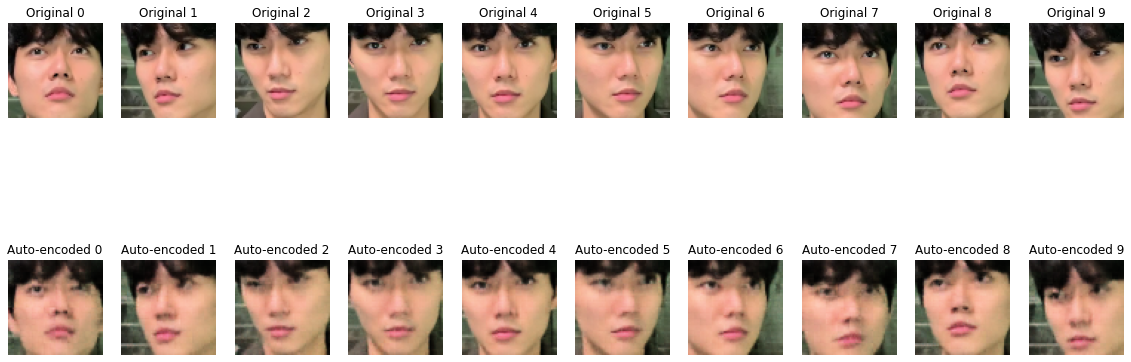

In [13]:
#이미지 출력
num = 10 
plt.figure(figsize=(20,8))

for i in range(10):
    # 원본 이미지
    ax = plt.subplot(2, num, i+1)
    plt.imshow(cv2.cvtColor(test_minsu[i*50], cv2.COLOR_BGR2RGB).reshape((64,64,3)))
    plt.title("Original %s" % str(i))
    plt.axis('off')
    
    # 복원 이미지
    ax = plt.subplot(2, num, i+num+1)
    plt.imshow(cv2.cvtColor(ae_images[i*50], cv2.COLOR_BGR2RGB).reshape((64,64,3)))
    plt.title("Auto-encoded %s" % str(i))
    plt.axis('off')
  
plt.show()

In [19]:
 # fid score 
    # generated images np
    #image_list = glob.glob(ae_images)
    #
    #real data set images np
    #Dimages_list = glob.glob(test_minsu)
    #Dimages = np.array([imread(str(fn)).astype(np.float32) for fn in files])


#with tf.Session() as sess:
#sess.run(tf.global_variables_initializer())
###mu_real, sigma_real = fid.calculate_activation_statistics(test_minsu, sess, batch_size=100) #test_minsu = Dimages 

#fid score deleted part
"""
stats_path = 'fid_stats.npz' # training set statistics 
f = np.load(stats_path)
mu_real, sigma_real = f['mu'][:], f['sigma'][:]
f.close()
"""

fid.create_inception_graph(inception_path)  # load the graph into the current TF graph


image_path = ae_images

def imread(filename):
    """
    Loads an image file into a (height, width, 3) uint8 ndarray.
    """
    return np.asarray(Image.open(filename), dtype=np.uint8)[..., :3]


#결과 images
inception_path = fid.check_or_download_inception(None) # download inception network
#image_list = glob.glob(os.path.join(ae_images, '*.jpg'))
#images = np.array([imread(str(fn)).astype(np.float32) for fn in image_list])

fid.create_inception_graph(inception_path)

sess = tf.compat.v1.Session()
sess.run(variables_initializer(global_variables())) #tf.global_variables_initializer()
mu_auto, sigma_auto = fid.calculate_activation_statistics(ae_images, sess, batch_size=100) #ae_images = images d
sess.close()
 
#fid score 결과
fid_value = fid.calculate_frechet_distance(mu_auto, sigma_auto, mu_real, sigma_real)
print("FID: %s" % fid_value)


KeyError: ignored

In [ ]:
#